## 0. Imports

In [67]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from matplotlib.ticker import ScalarFormatter

In [3]:
con = sqlite3.connect("sample.sqlite")

In [4]:
cur = con.cursor()

## 1. Give us short description of datasets

In [5]:
table_names = ['account', 'account_date_session', 'iap_purchase']

for name in table_names:
    cur.execute(f"PRAGMA table_info({name})")      # Execute the PRAGMA query to get table information for each table
    
    rows = cur.fetchall()                           # Fetch all the rows from the result set
                                                       
    print("Table " + str(name))                     # Print the table information
    for row in rows:
        print(row)
    print("\n")

Table account
(0, 'account_id', 'TEXT', 0, None, 0)
(1, 'created_time', 'timestamp', 0, None, 0)
(2, 'created_device', 'TEXT', 0, None, 0)
(3, 'created_platform', 'TEXT', 0, None, 0)
(4, 'country_code', 'TEXT', 0, None, 0)
(5, 'created_app_store_id', 'INT', 0, None, 0)


Table account_date_session
(0, 'account_id', 'TEXT', 0, None, 0)
(1, 'date', 'date', 0, None, 0)
(2, 'session_count', 'INT', 0, None, 0)
(3, 'session_duration_sec', 'INT', 0, None, 0)


Table iap_purchase
(0, 'account_id', 'TEXT', 0, None, 0)
(1, 'created_time', 'timestamp', 0, None, 0)
(2, 'package_id_hash', 'TEXT', 0, None, 0)
(3, 'iap_price_usd_cents', 'INT', 0, None, 0)
(4, 'app_store_id', 'INT', 0, None, 0)




Based on the description given for the task, we know that the data is from 2016, with three tables: <br>
<ul>
    <li>"account" table: for the user profiles</li>
    <li>"account_date_session" table: for the sessions of the users on active days </li>
    <li>"iap_purchase" table: in-app purchases of users</li>
</ul>
It also seems as when the tables were created, no primary key was assigned to them.

In [6]:
q_master = cur.execute("SELECT * FROM sqlite_master;")
q_master.fetchall()

[('table',
  'account',
  'account',
  2,
  'CREATE TABLE account \n( "account_id" text,\n\t"created_time" timestamp,\n\t"created_device" text,\n\t"created_platform" text,\n\t"country_code" text,\n\t"created_app_store_id" int \n)'),
 ('table',
  'iap_purchase',
  'iap_purchase',
  7460,
  'CREATE TABLE iap_purchase \n( "account_id" text,\n\t"created_time" timestamp,\n\t"package_id_hash" text,\n\t"iap_price_usd_cents" int,\n\t"app_store_id" int \n)'),
 ('table',
  'account_date_session',
  'account_date_session',
  8279,
  'CREATE TABLE account_date_session \n( "account_id" text,\n\t"date" date,\n\t"session_count" int,\n\t"session_duration_sec" int \n)')]

#### account table

Contains data regarding the accounts, the columns are the following: 
<ul>
    <li>'account_id': (presumed) primary key, text</li>
    <li>'created_time': time of account creation, timestamp </li>
    <li>'created_device': brand and make of the device on which the account was created, text</li>
    <li>'created_platform': OS of device account was created on, text</li>
    <li>'country code': country associated with account, text</li>
    <li>'created_app_store_id': presumably an ID associated with the app store where the account was created, int </li>
</ul>

In [7]:
q_account = cur.execute("SELECT * FROM account;")
q_account.fetchone()

('13514010', '2016-03-02 17:11:00.332', 'iPhone6,2', 'iOS', 'GB', 1)

#### account_date_session table

Contains data regarding the sessions of each account, the columns are the following: 
<ul>
    <li>'account_id': (presumed) primary key, text</li>
    <li>'date': date of the session, date </li>
    <li>'session_count': session counter, int </li>
    <li>'session_duration_sec': measure for the duration of a session in seconds, int</li>
</ul>

In [8]:
q_account_date_session = cur.execute("SELECT * FROM account_date_session;")
q_account_date_session.fetchone()

('68730811144', '2016-01-01', 1, 47)

#### iap_purchase table

Contains data regarding the in-app purchases, the columns are the following: 
<ul>
    <li>'account_id': (presumed) primary key, text</li>
    <li>'created_time': time of purchase, timestamp </li>
    <li>'package_id_hash': presumably a hashed version of an ID of the purchased product, text </li>
    <li>'iap_price_usd_cents': the price of the purchased product in cents, int</li>
    <li>'app_store_id':  presumably an ID associated with the app store platform<br> where the in-app purchase transaction happened, int</li>
</ul>

In [9]:
q_iap = cur.execute("SELECT * FROM iap_purchase;")
q_iap.fetchone()

('30077202816',
 '2016-03-26 23:59:59.355',
 'ae0253c27c34edd1ab4fe21d6bfc91f8',
 739,
 0)

### Dataframes

For the remainder of the data exploration and analysis, I have decided to convert the data to pandas DataFrames.

In [10]:
dataframes = {}

# Iterate through tables
for table_name in table_names:
    # Query the entire table
    query = f"SELECT * FROM {table_name};"
    
    # Use pandas to read the table into a DataFrame
    dataframes[table_name] = pd.read_sql_query(query, con)


# Access the DataFrames using their respective keys (table names)
account_df = dataframes['account']
account_date_session_df = dataframes['account_date_session']
iap_purchase_df = dataframes['iap_purchase']

In [53]:
df_names = [account_df, account_date_session_df, iap_purchase_df]

In [55]:
for df in df_names:
    print(sum(df.duplicated()))

0
0
0


In [56]:
for df in df_names:
    for column in df.columns:
        print("Unique values in " + str(column) + " column: " )
        print(df[column].unique())
    print("\n")

Unique values in account_id column: 
['13514010' '4308483975' '17193137415' ... '51554102314' '51554116380'
 '51554126520']
Unique values in created_time column: 
['2016-03-02T17:11:00.332000000' '2016-03-02T20:57:46.140000000'
 '2016-03-02T13:52:16.735000000' ... '2016-08-12T21:10:20.742000000'
 '2016-08-14T01:37:13.821000000' '2016-08-14T19:31:45.436000000']
Unique values in created_device column: 
['iPhone6,2' 'MIDC147PJ' 'SM-G360F' ... 'Z6' 'SGH-I777'
 'Energy Tablet 9 Neo 2']
Unique values in created_platform column: 
['iOS' 'Android']
Unique values in country_code column: 
['GB' 'FR' 'IT' 'CN' 'RU' 'ES' 'KR' 'NL' 'ID' 'SA' 'DE' 'US' 'IN' 'AT'
 'EG' 'CA' 'TR' 'MU' 'SV' 'PT' 'CZ' 'DK' 'IR' 'UA' 'SI' 'VN' 'AU' 'LK'
 'IQ' 'TN' 'PY' 'PE' 'BR' 'TH' 'MM' 'PH' 'KZ' 'DZ' 'GR' 'NZ' 'MX' 'FI'
 'CO' 'MY' 'CR' 'BD' 'LT' 'BE' 'JO' 'CL' 'EC' 'IL' 'PK' 'CH' 'GT' 'SE'
 'RO' 'HU' 'IE' 'AR' 'NO' 'TM' 'BA' 'ZA' 'NI' 'RS' 'JP' 'LU' 'BY' 'KH'
 'MD' 'TW' 'VE' 'LI' 'NP' 'LB' 'GH' 'MQ' 'SY' 'BO' 'UY' 'PL

#### account_df

In [11]:
account_df["created_time"] = account_df["created_time"].astype('datetime64')
account_df["created_app_store_id"] = account_df["created_app_store_id"].astype('int64')

In [12]:
account_df

,account_id,created_time,created_device,created_platform,country_code,created_app_store_id
0,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1
1,4308483975,2016-03-02 20:57:46.140,MIDC147PJ,Android,FR,2
2,17193137415,2016-03-02 13:52:16.735,SM-G360F,Android,IT,2
3,21488104920,2016-03-02 12:43:27.899,H60-L01,Android,CN,8
4,21488107995,2016-03-02 17:20:12.145,GT-I9500,Android,RU,2
...,...,...,...,...,...,...
112787,51554039942,2016-08-07 13:32:49.115,KOPO L128,Android,CN,4
112788,51554090637,2016-08-11 22:20:27.192,SM-G3608,Android,CN,15
112789,51554102314,2016-08-12 21:10:20.742,"iPhone8,4",iOS,US,1
112790,51554116380,2016-08-14 01:37:13.821,SM-G935F,Android,HR,2


In [13]:
account_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112792 entries, 0 to 112791
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   account_id            112792 non-null  object        
 1   created_time          112792 non-null  datetime64[ns]
 2   created_device        112792 non-null  object        
 3   created_platform      112792 non-null  object        
 4   country_code          112685 non-null  object        
 5   created_app_store_id  112792 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 5.2+ MB


There seem to be some records where the country_code is missing.

#### account_date_session_df

In [14]:
account_date_session_df["date"] = account_date_session_df["date"].astype('datetime64')
account_date_session_df["session_count"] = account_date_session_df["session_count"].astype('int64')
account_date_session_df["session_duration_sec"] = account_date_session_df["session_duration_sec"].astype('int64')

In [15]:
account_date_session_df

,account_id,date,session_count,session_duration_sec
0,68730811144,2016-01-01,1,47
1,68730812806,2016-01-01,1,204
2,68730829426,2016-01-01,12,4703
3,68730829426,2016-01-02,9,4676
4,68730829426,2016-01-03,9,2271
...,...,...,...,...
1698969,55850490316,2016-12-30,1,392
1698970,55850515956,2016-12-30,1,564
1698971,55850515956,2016-12-31,9,3268
1698972,55850519336,2016-12-31,9,4043


In [16]:
account_date_session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698974 entries, 0 to 1698973
Data columns (total 4 columns):
 #   Column                Dtype         
---  ------                -----         
 0   account_id            object        
 1   date                  datetime64[ns]
 2   session_count         int64         
 3   session_duration_sec  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 51.8+ MB


In [17]:
# Sum the missing values for each column
missing_values_summary = account_date_session_df.isnull().sum()

# Display the summary
print("Missing Values Summary:\n", missing_values_summary)

Missing Values Summary:
 account_id              0
date                    0
session_count           0
session_duration_sec    0
dtype: int64


There are no missing values in the account_date_session_df.

In [18]:
account_date_session_df.describe()

,session_count,session_duration_sec
count,1.698974e+06,1.698974e+06
mean,3.587891e+00,1.434244e+03
std,3.671223e+00,1.715709e+03
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,3.490000e+02
50%,2.000000e+00,8.660000e+02
75%,5.000000e+00,1.867000e+03
max,2.630000e+02,5.705000e+04


#### iap_purchase_df

In [19]:
iap_purchase_df["created_time"] = iap_purchase_df["created_time"].astype("datetime64")
iap_purchase_df["iap_price_usd_cents"] = iap_purchase_df["iap_price_usd_cents"].astype('int64')
iap_purchase_df["app_store_id"] = iap_purchase_df["app_store_id"].astype('int64') 

In [20]:
iap_purchase_df

,account_id,created_time,package_id_hash,iap_price_usd_cents,app_store_id
0,30077202816,2016-03-26 23:59:59.355,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0
1,30077202816,2016-05-31 11:24:37.283,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0
2,21487283560,2016-02-13 03:40:28.644,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
3,21487152816,2016-02-28 00:53:26.678,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
4,8602037685,2016-02-11 01:03:04.727,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
...,...,...,...,...,...
9904,51552698769,2016-07-23 03:25:58.870,99a9e0e63efa2fdce8fc8de74c66cea9,184,1
9905,51552698769,2016-07-25 05:57:33.827,99a9e0e63efa2fdce8fc8de74c66cea9,184,1
9906,51552698769,2016-11-14 01:01:11.202,efd2eebfdc98b55f9e6b45915d56f7ac,36,1
9907,51552698769,2016-12-02 13:43:30.761,efd2eebfdc98b55f9e6b45915d56f7ac,36,1


In [21]:
iap_purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   account_id           9909 non-null   object        
 1   created_time         9909 non-null   datetime64[ns]
 2   package_id_hash      9909 non-null   object        
 3   iap_price_usd_cents  9909 non-null   int64         
 4   app_store_id         9909 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 387.2+ KB


There are no missing values in the iap_purchase_df either.

In [22]:
iap_purchase_df.describe()

,iap_price_usd_cents,app_store_id
count,9909.000000,9909.000000
mean,429.090927,2.689777
std,681.551349,4.773476
min,36.000000,0.000000
25%,36.000000,0.000000
50%,184.000000,1.000000
75%,369.000000,2.000000
max,3699.000000,19.000000


## 2. Analyse the daily active users

### Compare DAU changes over time

In [23]:
users_per_day = account_date_session_df.groupby('date')['session_duration_sec'].sum()
users_per_day

date
2016-01-01    1514859
2016-01-02    2614779
2016-01-03    3252511
2016-01-04    3258850
2016-01-05    3591406
               ...   
2016-12-27    6039882
2016-12-28    6087116
2016-12-29    5703026
2016-12-30    6556882
2016-12-31    6677768
Name: session_duration_sec, Length: 366, dtype: int64

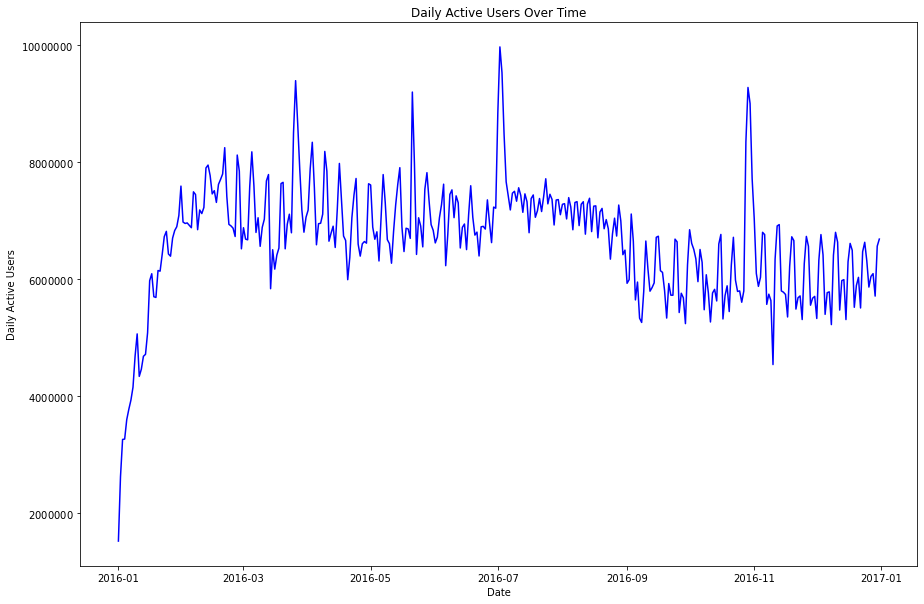

In [68]:
plt.figure(figsize=(15, 10))
plt.plot(users_per_day, linestyle='-', color='b')

# Adding labels and title
plt.title('Daily Active Users Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Active Users')

plt.rcParams.update({'font.size': 10})
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(formatter)

# Display the plot
plt.show()

Seasonal decomposition using moving averages:

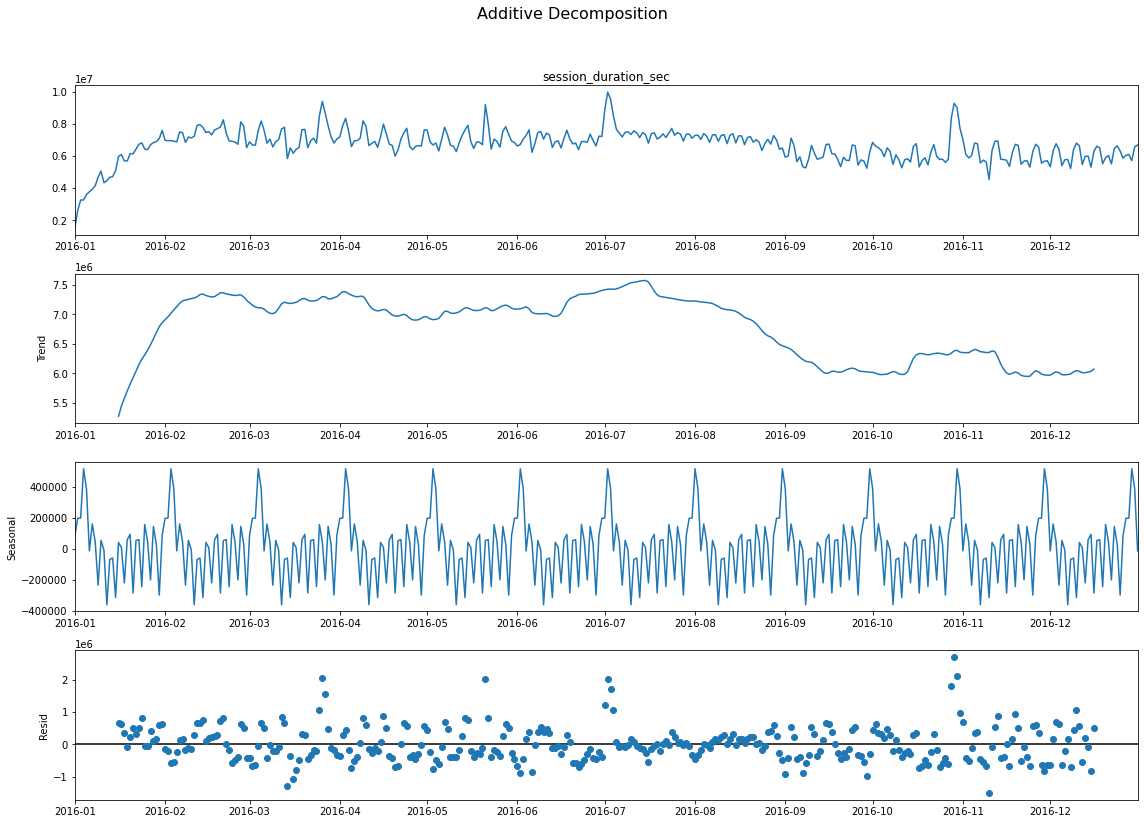

In [25]:
# Multiplicative Decomposition 
# multiplicative_decomposition = seasonal_decompose(users_per_day, model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(users_per_day, model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})

# multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#### Can you identify any trends in data?

Overall there is no apparent trend in the data over the 2016 period, but there are some parts of the year with different characteristics regarding the daily user activity:
<ul>
    <li>From January to the end of February/beginning of March, there is a clear growth of user activity (perhaps this is when the game was launched).</li>
    <li>From the beginning of March to the middle of August, the user activity fluctuates around the same peak level. </li>
    <li>At the end of August the user activity begins to decline untile it reaches a bottom value in the middle of September. </li>
    <li>A minor uptick of user activity can be seen from around the 15th of October to the 15th of November, after which the daily user activity returns to the low values seen from the middle of September.</li>
    <li>There is also a clear seasonality, with the daily user activity peaking at the beginning of each month (perhaps related to monthly patches or updates).</li>
</ul>

#### Can you find any ups or drops that are out of the normal behaviour?

In [26]:
outliers_fraction = float(.035)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(users_per_day.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(contamination=0.035)

In [27]:
users_per_day_df = pd.DataFrame(users_per_day)
users_per_day_df

,session_duration_sec
date,
2016-01-01,1514859
2016-01-02,2614779
2016-01-03,3252511
2016-01-04,3258850
2016-01-05,3591406
...,...
2016-12-27,6039882
2016-12-28,6087116
2016-12-29,5703026


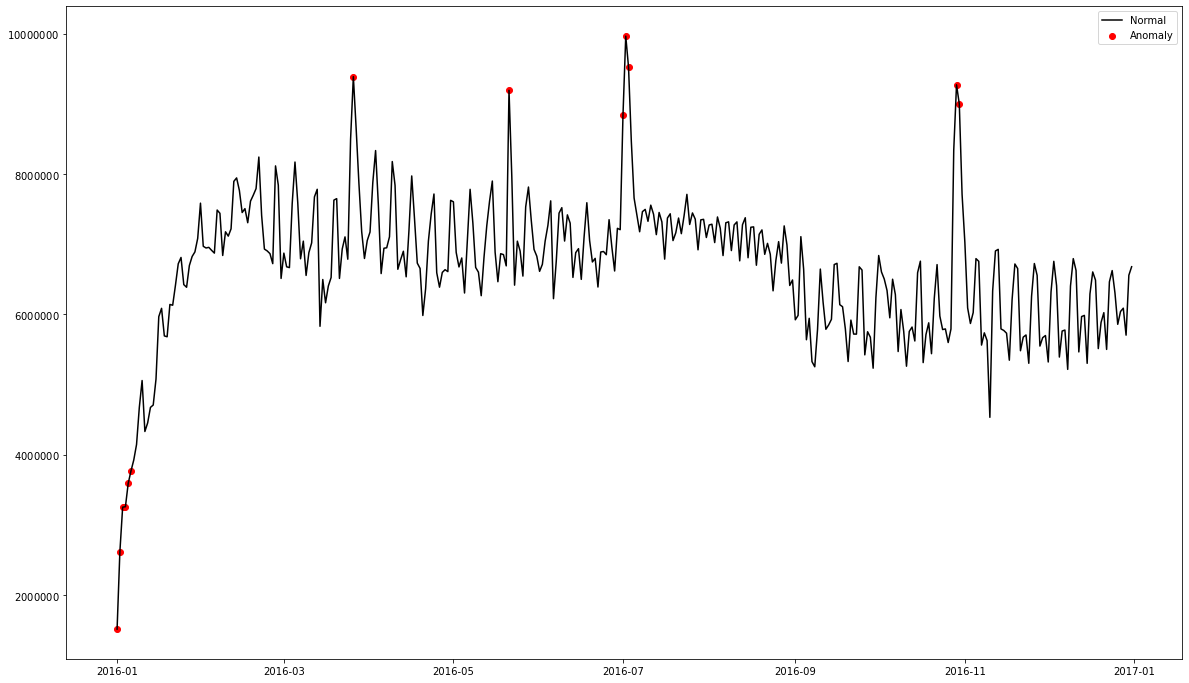

In [69]:
users_per_day_df['anomaly'] = model.predict(data)
# visualization
fig, ax = plt.subplots(figsize=(20,12))
a = users_per_day_df.loc[users_per_day_df['anomaly'] == -1, ['session_duration_sec']] #anomaly
ax.plot(users_per_day_df.index, users_per_day_df['session_duration_sec'], color='black', label = 'Normal')
ax.scatter(a.index,a['session_duration_sec'], color='red', label = 'Anomaly')

plt.rcParams.update({'font.size': 10})
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend()
plt.show();

In [84]:
users_per_day_df.loc[users_per_day_df['anomaly'] == -1].iloc[6:]

,session_duration_sec,anomaly
date,,
2016-03-26,9385923,-1
2016-05-21,9191107,-1
2016-07-01,8833646,-1
2016-07-02,9962866,-1
2016-07-03,9522627,-1
2016-10-29,9269673,-1
2016-10-30,8996787,-1


#### What do you think why do they happen?

I had several hypotheses as to explain these outliers in user activity, based on the data available:
<ul>
    <li>The surge in activity is due to the game being released in new countries/markets. This however was proven false as seen on the chart below (there is no spike of activity from a previously inactive country)</li>
    <li>Upon seeing that CN (China) has the overwhelming majority in activity, I searched for Chinese holidays in case they aligned with these dates. Unfortunately they did not.</li>
    <li>The next hypothesis was that perhaps a new popular device, such as an iPhone was released around the same time as one of the peaks. However, in 2016, none of the released iOS products line up with these dates.</li>
    <li>Final idea was that perhaps there were some major promotions or discounts in the app at these times. However, from the data available, this is cannot be proven clearly. The plot of the amount of money spent daily does not line up with the activity spikes, so this hypothesis cannot be proven either.</li>
</ul>

As I could not derive the reasoning for these spikes from the data, I can only provide a general answer: the spikes in activity are most likely due to major advertising campaigns, or perhaps major content updates that drove players on these dates to the game. The dates of the activity spikes should be cross-examined with the update cycle and marketing plan for the game to confirm this hypothesis, to which unfortunately I do not have access to. 

#### Spent amounts per day (hypothesis #4)

In [30]:
iap_purchase_df["date"] = iap_purchase_df["created_time"].dt.date

In [31]:
spent_per_day = iap_purchase_df.groupby('date')['iap_price_usd_cents'].sum()
spent_per_day

date
2016-01-01      476
2016-01-02     4678
2016-01-03     6047
2016-01-04    21872
2016-01-05     7890
              ...  
2016-12-27    12485
2016-12-28     7824
2016-12-29     5834
2016-12-30     4931
2016-12-31    12640
Name: iap_price_usd_cents, Length: 366, dtype: int64

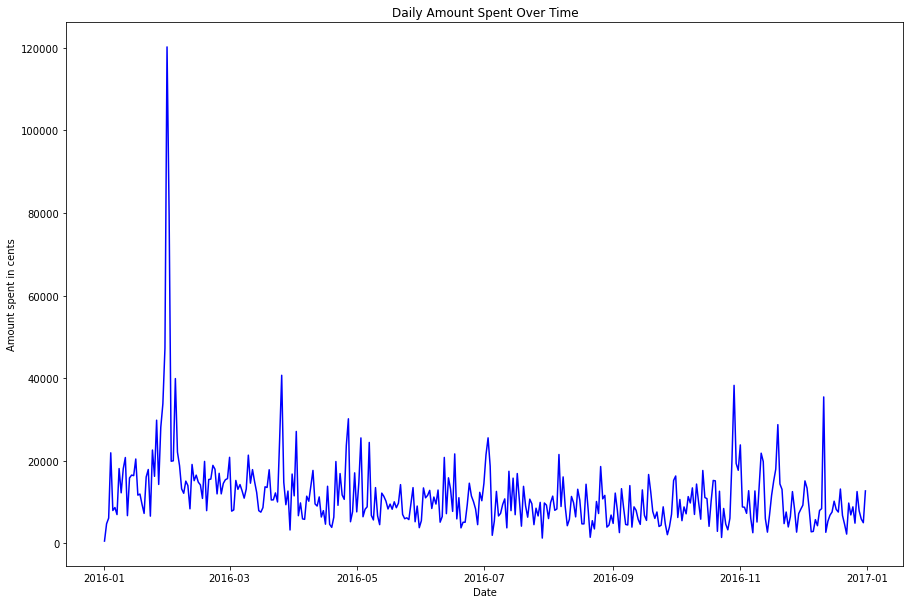

In [73]:
plt.figure(figsize=(15, 10))
plt.plot(spent_per_day, linestyle='-', color='b')

# Adding labels and title
plt.title('Daily Amount Spent Over Time')
plt.xlabel('Date')
plt.ylabel('Amount spent in cents')

# Display the plot
plt.show()

#### Daily active accounts per country (hypothesis #1)

In [33]:
session_account_df = pd.merge(account_df, account_date_session_df, on='account_id', how='inner')

# Display the merged DataFrame
print(session_account_df)

          account_id            created_time created_device created_platform  \
0           13514010 2016-03-02 17:11:00.332      iPhone6,2              iOS   
1           13514010 2016-03-02 17:11:00.332      iPhone6,2              iOS   
2           13514010 2016-03-02 17:11:00.332      iPhone6,2              iOS   
3           13514010 2016-03-02 17:11:00.332      iPhone6,2              iOS   
4           13514010 2016-03-02 17:11:00.332      iPhone6,2              iOS   
...              ...                     ...            ...              ...   
1698969  51554116380 2016-08-14 01:37:13.821       SM-G935F          Android   
1698970  51554116380 2016-08-14 01:37:13.821       SM-G935F          Android   
1698971  51554116380 2016-08-14 01:37:13.821       SM-G935F          Android   
1698972  51554116380 2016-08-14 01:37:13.821       SM-G935F          Android   
1698973  51554126520 2016-08-14 19:31:45.436        iPad3,1              iOS   

        country_code  created_app_store

In [34]:
users_per_day_country = session_account_df.groupby(['date', 'country_code'])
users_per_day_country 

In [35]:
users_per_day_country.size()

date        country_code
2016-01-01  AE               1
            AR               9
            AT               3
            AU              13
            BD               3
                            ..
2016-12-31  UZ               3
            VE              10
            VN              39
            YE               9
            ZA               8
Length: 42302, dtype: int64

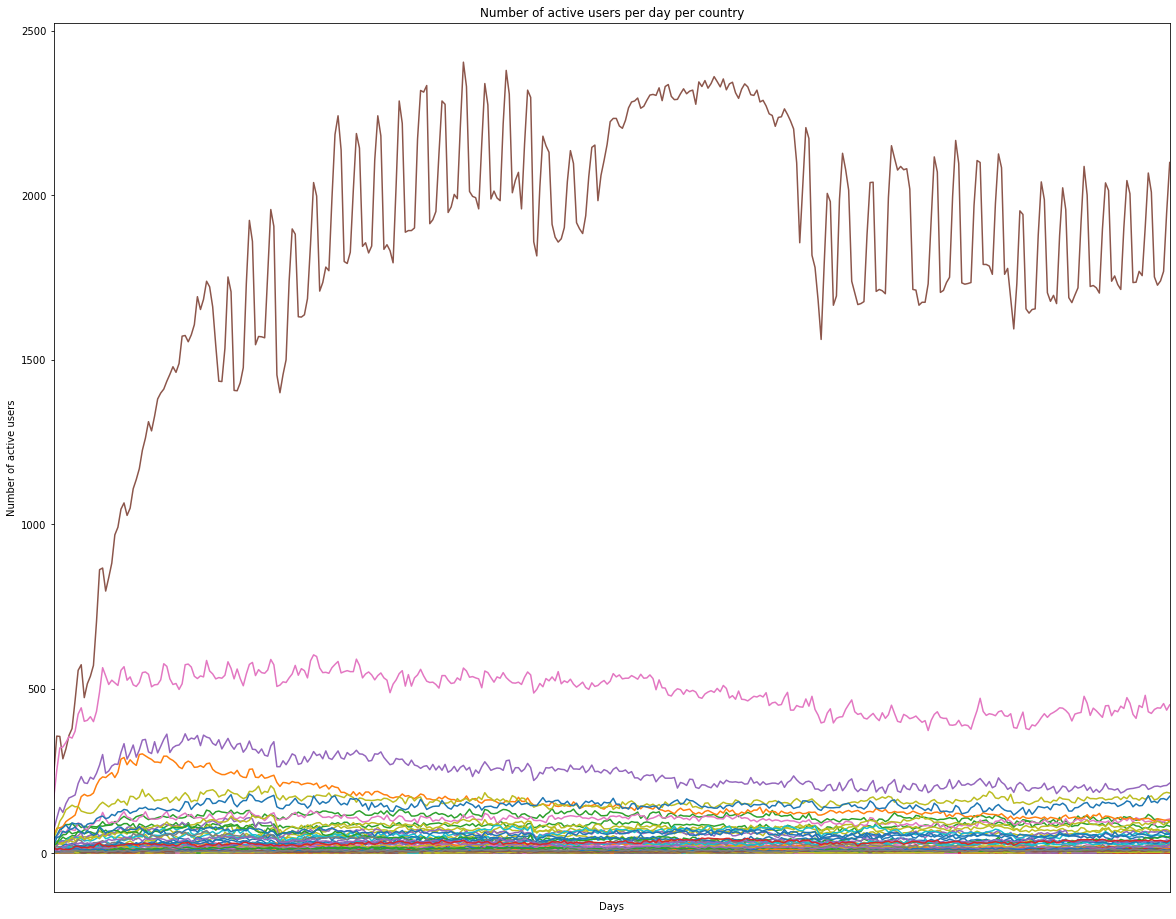

In [71]:
ax = users_per_day_country.size().unstack().plot(kind='line', figsize=(20, 16), legend=None)
plt.title('Number of active users per day per country')
plt.xlabel('Days')
plt.ylabel('Number of active users')
# Add a legend
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.set_xticks([])

# Display the plot
plt.savefig('stacked_bar_chart.png', dpi=500)

In [37]:
 session_account_df.groupby(['country_code'])["account_id"].count().sort_values(ascending=False)

country_code
CN    674662
US    177093
FR     88995
RU     58156
KR     57718
       ...  
TO         1
BQ         1
ML         1
SZ         1
MS         1
Name: account_id, Length: 189, dtype: int64

## 3. Analyse sales

#### Geographic split of the revenue

In [38]:
iap_account_df = pd.merge(account_df, iap_purchase_df, on='account_id', how='inner')
iap_account_df

,account_id,created_time_x,created_device,created_platform,country_code,created_app_store_id,created_time_y,package_id_hash,iap_price_usd_cents,app_store_id,date
0,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1,2016-03-11 09:16:29.313,99a9e0e63efa2fdce8fc8de74c66cea9,184,0,2016-03-11
1,14894920,2016-06-25 14:09:19.562,HUAWEI P7-L09,Android,CN,3,2016-06-29 14:47:41.680,efd2eebfdc98b55f9e6b45915d56f7ac,36,3,2016-06-29
2,12365400,2016-01-02 11:18:20.305,"iPhone8,1",iOS,CN,1,2016-09-16 13:08:40.206,efd2eebfdc98b55f9e6b45915d56f7ac,36,10,2016-09-16
3,12365400,2016-01-02 11:18:20.305,"iPhone8,1",iOS,CN,1,2016-09-18 09:49:06.686,99a9e0e63efa2fdce8fc8de74c66cea9,184,10,2016-09-18
4,12365400,2016-01-02 11:18:20.305,"iPhone8,1",iOS,CN,1,2016-09-20 07:49:32.397,99a9e0e63efa2fdce8fc8de74c66cea9,184,10,2016-09-20
...,...,...,...,...,...,...,...,...,...,...,...
9904,51551668381,2016-02-03 00:11:32.506,"iPhone8,2",iOS,KR,1,2016-02-05 21:57:41.794,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0,2016-02-05
9905,51551668381,2016-02-03 00:11:32.506,"iPhone8,2",iOS,KR,1,2016-02-06 13:01:37.169,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0,2016-02-06
9906,51551668381,2016-02-03 00:11:32.506,"iPhone8,2",iOS,KR,1,2016-02-08 14:58:56.091,99a9e0e63efa2fdce8fc8de74c66cea9,184,0,2016-02-08
9907,51551668381,2016-02-03 00:11:32.506,"iPhone8,2",iOS,KR,1,2016-02-08 22:59:28.875,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0,2016-02-08


In [39]:
revenue_by_region = iap_account_df.groupby('country_code')['iap_price_usd_cents'].sum()
revenue_by_region

country_code
AE       1953
AR        920
AT      28471
AU      45066
BE       1291
BH       1475
BR       8598
CA     254506
CH     182774
CN    1136507
CO      45860
CY        368
CZ       1289
DE      94621
DK       4976
DO        184
EG        110
ES      17581
FI       4061
FR     152739
GB     145086
GR       5543
ID        368
IE        552
IL        184
IN        184
IQ        368
IT      15230
JP      14041
KH        738
KR     463518
KW       2954
MX       6266
MY        184
NL       7598
NZ       6093
PA        184
PL       1399
PT       2211
RE       2033
RU      30102
SA      32092
SE      16420
SG       1290
TR     193339
UA       1473
US    1314818
VE        369
ZA       1478
Name: iap_price_usd_cents, dtype: int64

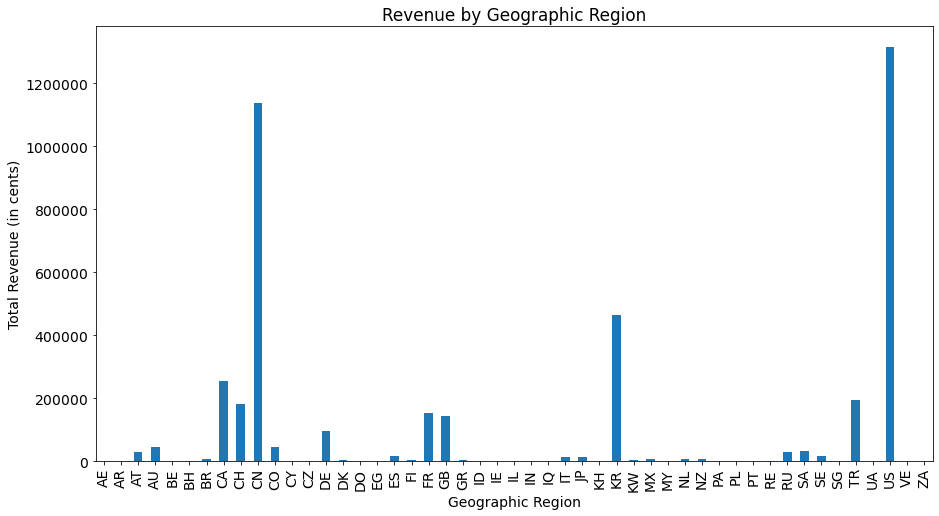

In [77]:
revenue_by_region.plot(kind='bar', figsize=(15, 8))

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(formatter)

plt.rcParams.update({'font.size': 14})

plt.title('Revenue by Geographic Region')
plt.xlabel('Geographic Region')
plt.ylabel('Total Revenue (in cents)')
plt.show()

#### Geographic split of the users

In [41]:
users_by_region = iap_account_df.groupby('country_code')['account_id'].count()
users_by_region

country_code
AE       8
AR       5
AT      19
AU     148
BE       4
BH       5
BR      23
CA     387
CH     117
CN    4610
CO      20
CY       2
CZ       6
DE     210
DK      19
DO       1
EG       1
ES      31
FI       9
FR     367
GB     435
GR       7
ID       2
IE       3
IL       1
IN       1
IQ       2
IT      51
JP      19
KH       2
KR     536
KW       6
MX      24
MY       1
NL      24
NZ      12
PA       1
PL       7
PT       9
RE       2
RU      90
SA      61
SE      45
SG       5
TR     208
UA       7
US    2345
VE       1
ZA       2
Name: account_id, dtype: int64

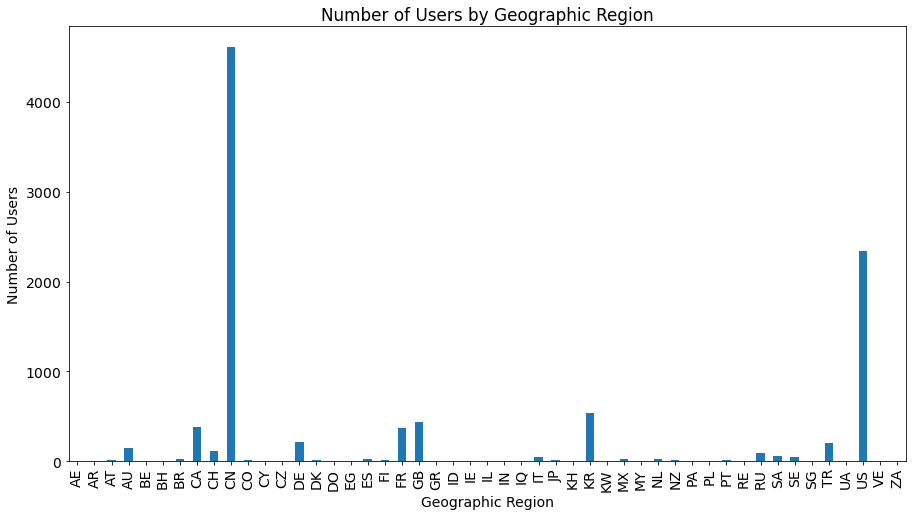

In [79]:
# Bar chart
users_by_region.plot(kind='bar', figsize=(15, 8))

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Number of Users by Geographic Region')
plt.xlabel('Geographic Region')
plt.ylabel('Number of Users')
plt.show()

####  Calculate average revenue per user per market

In [43]:
grouped_data = iap_account_df.groupby(['country_code', 'account_id'])['iap_price_usd_cents'].sum().reset_index()

# Calculate average revenue per user per market
average_revenue_per_user_per_market = grouped_data.groupby('country_code')['iap_price_usd_cents'].mean()

# Display the result
print(average_revenue_per_user_per_market)

country_code
AE      976.500000
AR      460.000000
AT    28471.000000
AU     1733.307692
BE      430.333333
BH     1475.000000
BR     1433.000000
CA     6059.666667
CH    20308.222222
CN     1300.351259
CO    45860.000000
CY      368.000000
CZ      644.500000
DE     2956.906250
DK     1244.000000
DO      184.000000
EG      110.000000
ES     3516.200000
FI     2030.500000
FR     2727.482143
GB     2545.368421
GR     2771.500000
ID      368.000000
IE      552.000000
IL      184.000000
IN      184.000000
IQ      184.000000
IT     2538.333333
JP     4680.333333
KH      738.000000
KR     6437.750000
KW     2954.000000
MX      696.222222
MY      184.000000
NL     1519.600000
NZ     6093.000000
PA      184.000000
PL      699.500000
PT     1105.500000
RE     2033.000000
RU     1770.705882
SA     3209.200000
SE     3284.000000
SG      645.000000
TR     9666.950000
UA      736.500000
US     5301.685484
VE      369.000000
ZA     1478.000000
Name: iap_price_usd_cents, dtype: float64


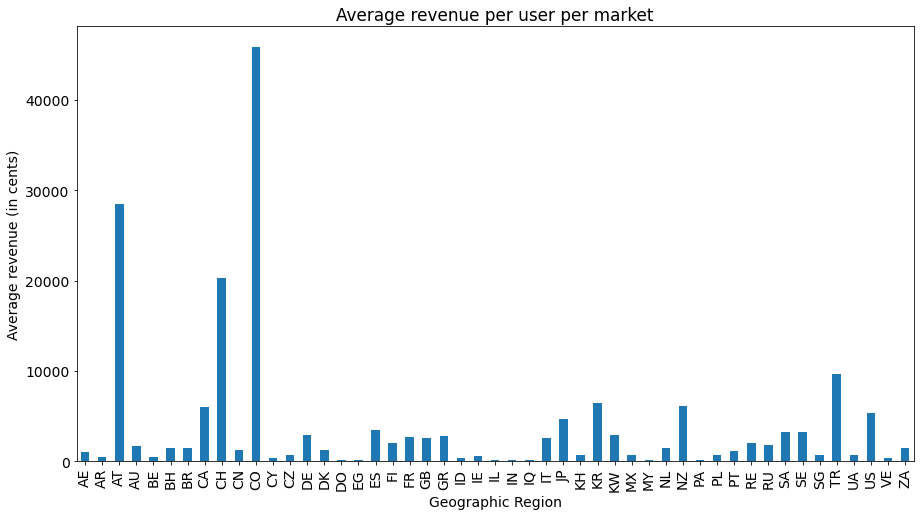

In [81]:
# Bar chart
average_revenue_per_user_per_market.plot(kind='bar', figsize=(15, 8))
plt.title('Average revenue per user per market')
plt.xlabel('Geographic Region')
plt.ylabel('Average revenue (in cents)')
plt.show()

#### What are your observations of the results?

<ul>
    <li>The highest revenues are from the US and China (CN).</li>
    <li>The highest number of users are also from the US and China (CN).</li>
    <li>However, the average revenue per user is very low for both the US and China. The highest average revenue per user is in Austria (AT), Colombia (CO), and Switzerland (CH).</li>
</ul>